In [1]:
from ada_csl_wrc.evaluation import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from ada_csl_wrc.models import CostSensitiveDecisionTreeClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from ada_csl_wrc.models import ConstrainedCSDecisionTree
from ada_csl_wrc.models import Constrained
from sklearn.model_selection import train_test_split
from ada_csl_wrc.utils import prediction_up_to_constraint
from ada_csl_wrc.utils import prepare_for_cost_cle
from ada_csl_wrc.utils import filter_only_worst_features
from ada_csl_wrc.utils import find_effective_threshold
import json
import pickle
from copy import deepcopy


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


loaded ada_csl_wrc.utils


### Hyperparameters of the experiment


In [2]:
COST_FALSE_NEGATIVE = 10
COST_FALSE_POSITIVE = 1
t = COST_FALSE_POSITIVE/(COST_FALSE_POSITIVE+COST_FALSE_NEGATIVE)
COST_MATRIX = np.array([[0, COST_FALSE_POSITIVE], [COST_FALSE_NEGATIVE, 0]])
FEATURES_RATIO = 1.0

In [3]:
COST_MATRIX

array([[ 0,  1],
       [10,  0]])

### Data-specific code

This part includes some data-specific code. It is not included in the final model. <br>
The X and the y are the dataframes that are used for training and testing.


In [26]:
cs_best_params = json.load(open("./config/cost_sensitive_best_params.json", "r")) #hard-coded in a json file
#dt_best_params = find_best_params(dt_param_grid, X, y) #find it using grid search
dt_best_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

In [4]:
df = pd.read_csv('./data/feature_dataset.csv')#, index_col='credentialset_id')


In [5]:
df.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,max_time_120d,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl,target
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,14,1,0.349653,0.459135,0.730769,3.0,3.0,0.0,1.0,0.0
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.000000,0.000000,3.0,4.0,0.0,1.0,0.0
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.314904,0.115385,2.0,5.0,0.0,1.0,0.0
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.375000,0.576923,2.0,5.0,0.0,1.0,0.0
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.472500,0.560000,2.0,5.0,0.0,1.0,0.0


In [6]:
provider_ids = pickle.load(open("data\provider_ids.pickle", "rb"))

In [7]:
df_with_provider = df.join(provider_ids, on='credentialset_id')
df_with_provider.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl,target,provider_id
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,1,0.349653,0.459135,0.730769,3.0,3.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,1,0.349653,0.000000,0.000000,3.0,4.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,1,0.349653,0.314904,0.115385,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,1,0.349653,0.375000,0.576923,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,1,0.349653,0.472500,0.560000,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9


In [8]:
df_with_provider['provider_id'].value_counts()

867c4a38-0d75-46ff-a4c2-f44cb63be2c9    960
a12f6956-9aca-4550-8caa-2e2f9532674c    540
b954c933-d771-4dc0-8f4f-89db56cf7266    180
ddcca177-076a-4389-b357-bc03fa194438    120
50b5a2d8-06d1-4d8d-b8b3-2b945e7c35d6    120
9b9f5ceb-dea2-49db-8476-4530c1b0c92d    120
22f309a8-1746-49a7-bf6c-678729834573    120
856f211d-c66e-4db7-b910-7419900a70e1    120
451e185d-5ad1-469f-8c33-164884140ffc    120
6f8bd649-7125-40a7-818b-4cc67a4863d2     60
02531004-4599-4177-9d7d-00bc85a200c6     60
3c705cbf-e196-40cf-a4fa-f49e5edf4255     60
614de8cc-42e2-4afc-8490-da3c7fe5ba91     60
324ebb81-07ca-4fa2-9235-6f023e806cdd     60
58b25639-e6ba-4ff0-aed1-5ca66c8debb0     60
402b1bde-d71d-4932-a514-95a2334eb586     60
148d76c1-3e78-4581-b909-e4abd3496e12     60
b8c85476-b870-4de4-ade1-fc8804e8b4bc     60
63a50dc0-315c-485a-b497-c8efb89eff3f     60
9638be39-8160-4fa6-8093-1434234885cb     60
dc4abe91-b03f-4dd2-9987-102db5767235     60
75f8d952-be81-4e22-951e-41b291d211f2     60
444b0293-8056-47e0-a3c8-cd7bca49

In [285]:
def predict_constrained_cs(X_train, X_test, y_train, y_test, constraint, cs_best_params):
    #initialize the threshold
    threshold = 0.0
    effective_threshold = 1.0
    lower_bound = 0.0
    upper_bound = 1000.0 #Should be a big number, I don't know what is big enough
    cfp = 0
    cfn = 10
    results_dict = {}
    cm_dict = {}
    i = 0
    
    #High CFP increase the threshold and vice versa
    while (effective_threshold > threshold) or (abs(upper_bound - lower_bound) > 1.0):
    #for i in range(50):
    
        print(
            f"Threshold: {threshold:.2f}", 
            f"Effective Threshold: {effective_threshold:.2f}", 
            f"Cost False Positive: {cfp:.2f}", 
            f"Lower Bound: {lower_bound:.2f}",
            f"Upper Bound: {upper_bound:.2f}",
            sep = " ", end="\r", flush=True)
        
        threshold = cfp/(cfp+cfn)
        cost_matrix = np.array([[0, cfp], 
                                [cfn, 0]])
        model_i = CostSensitiveDecisionTreeClassifier() #The base object, we will train it.
        model_i.set_params(**cs_best_params)
        model_i.fit(X_train.to_numpy(), y_train.to_numpy(), cost_mat = prepare_for_cost_cle(len(X_train), cost_matrix)) 
        y_pred_proba = model_i.predict_proba(X_test.to_numpy())[:, 1]
        effective_threshold = find_effective_threshold(y_pred_proba, constraint, threshold) 
        y_pred = prediction_up_to_constraint(y_pred_proba, constraint)
        results_dict[i] =  evaluate(y_test, y_pred, COST_MATRIX)
        cm_dict[i] = confusion_matrix(y_test, y_pred)
    
        #The binary search, if we overshot, we need to decrease cfp
        if effective_threshold <= threshold: #It means we have found a good cfp, but might not be the best
            upper_bound = cfp
            cfp = (cfp+lower_bound)/2
                  
        else: #We undershot, we need to increase cfp
            lower_bound = cfp
            cfp = (cfp+upper_bound)/2
        i+=1
        
    best_model_ = deepcopy(model_i) #This one is already trained.
    cfp_ = cfp
    threshold_ = threshold
    
    print("\nDONE")
    print(f"Threshold: {threshold:.2f}")
    print(f"Effective threshold: {effective_threshold:.2f}")
    print("Current cfp: ", cfp)
    print("Lower bound: ", lower_bound)
    print("Upper bound: ", upper_bound)
    return best_model_, results_dict, cm_dict

In [ ]:
dt_best_params

In [286]:
def predict_dt(X_train, X_test, y_train, y_test, constraint, dt_best_params):
    dt_model = DecisionTreeClassifier(**dt_best_params)
    dt_model.fit(X_train, y_train)
    y_pred_proba = dt_model.predict_proba(X_test)[:, 1]
    y_pred = prediction_up_to_constraint(y_pred_proba, constraint)
    return dt_model, evaluate(y_test, y_pred, COST_MATRIX), confusion_matrix(y_test, y_pred)

In [287]:
mask_test_provider = df_with_provider['provider_id'] == '867c4a38-0d75-46ff-a4c2-f44cb63be2c9'
test_dates = df['prediction_date'].unique()[-10:]
results_dates_dict ={}
for i, date in enumerate(test_dates):
    mask_train_dates = df['prediction_date'].isin(df['prediction_date'].unique()[i:-10+i])
    mask_test_date = df['prediction_date'] == date
    X_train = df[mask_train_dates].drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
    X_test = df[mask_test_provider & mask_test_date].drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
    y_train = df[mask_train_dates]['target']
    y_test = df[mask_test_date & mask_test_provider]['target']
    constraint = y_test.sum()/len(y_test)*0.5
    cs_best_model_, cs_results_dict, cs_cm_dict = predict_constrained_cs(X_train, X_test, y_train, y_test, constraint, cs_best_params)
    dt_model, dt_results_dict, dt_cm = predict_dt(X_train, X_test, y_train, y_test, constraint, dt_best_params)
    results_dates_dict[date] = {'cs_best_model_': cs_best_model_, 'cs_results_dict': cs_results_dict, 'cs_cm_dict': cs_cm_dict, 'dt_model': dt_model, 'dt_results_dict': dt_results_dict, 'dt_cm': dt_cm}

Threshold: 0.79 Effective Threshold: 0.79 Cost False Positive: 36.13 Lower Bound: 35.16 Upper Bound: 37.11
DONE
Threshold: 0.78
Effective threshold: 0.78
Current cfp:  35.64453125
Lower bound:  35.15625
Upper bound:  36.1328125
Threshold: 0.72 Effective Threshold: 0.72 Cost False Positive: 24.41 Lower Bound: 23.44 Upper Bound: 25.39
DONE
Threshold: 0.71
Effective threshold: 0.71
Current cfp:  23.92578125
Lower bound:  23.4375
Upper bound:  24.4140625
Threshold: 0.77 Effective Threshold: 0.77 Cost False Positive: 32.23 Lower Bound: 31.25 Upper Bound: 33.20
DONE
Threshold: 0.76
Effective threshold: 0.76
Current cfp:  31.73828125
Lower bound:  31.25
Upper bound:  32.2265625
Threshold: 0.76 Effective Threshold: 0.77 Cost False Positive: 32.71 Lower Bound: 32.23 Upper Bound: 33.20
DONE
Threshold: 0.77
Effective threshold: 0.77
Current cfp:  32.470703125
Lower bound:  32.2265625
Upper bound:  32.71484375
Threshold: 0.77 Effective Threshold: 0.77 Cost False Positive: 32.23 Lower Bound: 31.25 

In [297]:
def plot_cs_dt_metric(results_dates_dict, metric):
    cs_metric, dt_metric = [], []
    for date in test_dates:
        cs_result = results_dates_dict[date]['cs_results_dict']
        cs_metric.append([cs_result[k][metric] for k in cs_result.keys()][-1])
        dt_metric.append(results_dates_dict[date]['dt_results_dict'][metric])
    plt.plot(test_dates, cs_metric, label='cs')
    plt.plot(test_dates, dt_metric, label='dt')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

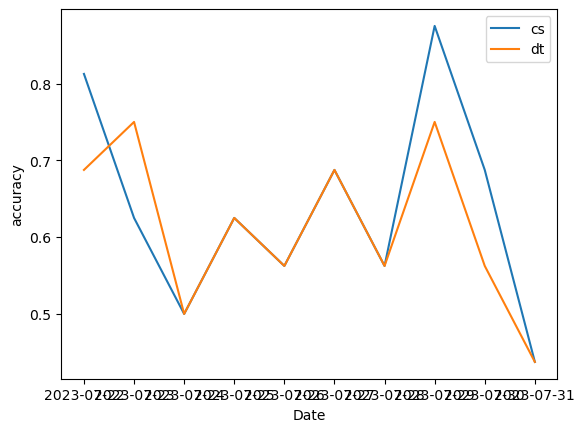

In [298]:
plot_cs_dt_metric(results_dates_dict, 'accuracy')

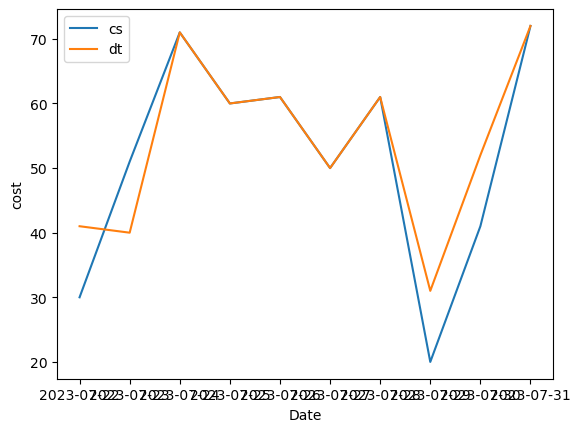

In [299]:
plot_cs_dt_metric(results_dates_dict, 'cost')

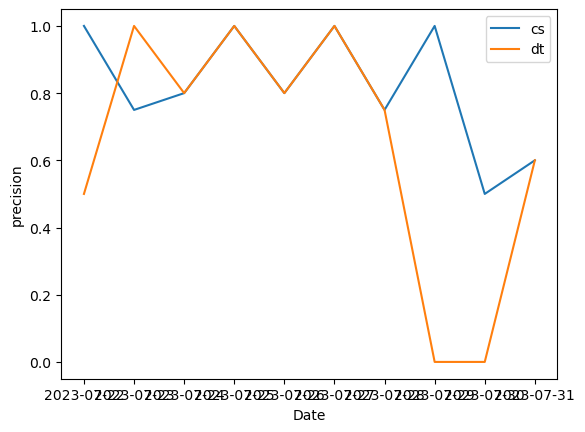

In [300]:
plot_cs_dt_metric(results_dates_dict, 'precision')

In [ ]:
#add comparison between model_i to model_i-1